In [67]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from scipy.stats import beta

**Goal:** improve the world's limit on the area of the Mandelbrot set.

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is a set of [complex numbers](https://en.wikipedia.org/wiki/Complex_number) $c$ for which

$$z_{i + 1} = |z_i|^2 + c \mbox{ with } z_0 = 0$$

does not diverge to infinity. That is, the set $c$ for which $|z_i| \to \infty$ as $i \to \infty$. Sequences $z_i$ that cycle or converge to any finite point are considered in the set; anything else is outside the set.

The following function identifies whether a _point_ $c = x + y i$ is in the Mandelbrot set or not ($x$ and $y$ are real numbers and $i = \sqrt{-1}$). It uses 32-bit (single precision) floating point to approximate real numbers (`np.complex64` is made of two `np.float32`). The algorithm tracks $z_i$ for two consecutive $i$, named "tortoise" and "hare" because [the hare is ahead of the tortoise](https://en.wikipedia.org/wiki/The_Tortoise_and_the_Hare) by a factor of 2. This is [Floyd's algorithm](https://en.wikipedia.org/wiki/Cycle_detection#Floyd%27s_tortoise_and_hare) for detecting cycles in a sequence (including the "cycle" of converging to a point).

In [15]:
@nb.jit
def is_in_mandelbrot(x, y):
    c = np.complex64(x) + np.complex64(y)*np.complex64(1j)
    z_hare = z_tortoise = np.complex64(0)
    while True:
        z_hare = z_hare*z_hare + c
        z_hare = z_hare*z_hare + c
        z_tortoise = z_tortoise*z_tortoise + c
        if z_hare == z_tortoise:
            return True      # orbiting or converging to zero
        if z_hare.real**2 + z_hare.imag**2 > 4:
            return False     # diverging to infinity

There's a mathematical theorem ([Knill (2023)](https://doi.org/10.48550/arXiv.2305.17848), section 4.7) that proves that the Mandelbrot set is entirely contained within $x \in (-2, 1)$, $y \in (-\frac{3}{2}, \frac{3}{2})$.

If $|z_i|^2 > 4$, then the $z_{i+1}$ with the smallest magnitude in that box is at $c = -2 + 0 i$, and that $z_{i+1} > 2$, which also has magnitude greater than $4$, so if a sequence ever exceeds $|z_i|^2 > 4$, then it diverges to infinity.

Let's take a look at it.

In [22]:
@nb.jit(parallel=True)
def draw_mandelbrot(num_x, num_y):
    xmin, xmax = -2, 1
    ymin, ymax = -3/2, 3/2
    
    pixels = np.empty((num_x, num_y), np.int32)
    dx = (xmax - xmin) / num_x
    dy = (ymax - ymin) / num_y
    
    for i in nb.prange(num_x):
        for j in nb.prange(num_y):
            x = xmin + i*dx
            y = ymin + j*dy
            pixels[i, j] = is_in_mandelbrot(x, y)

    return pixels

In [25]:
pixels = draw_mandelbrot(500, 500)

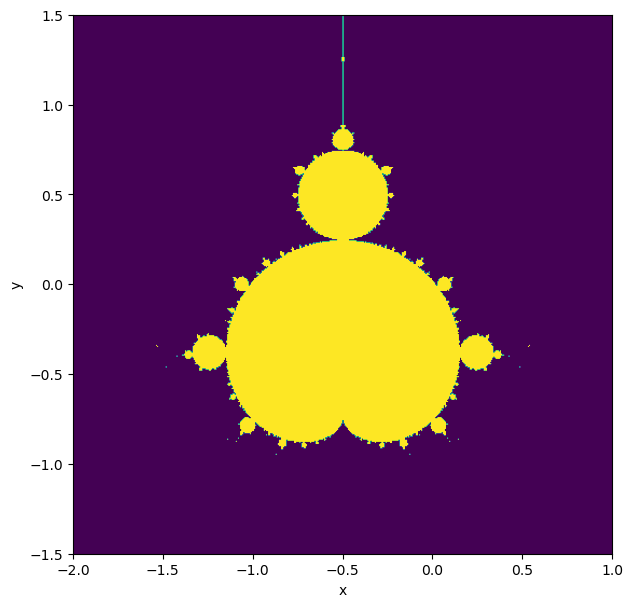

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(pixels, extent=[-2, 1, -3/2, 3/2])
ax.set_xlabel("x")
ax.set_ylabel("y")

None

The exact area of the Mandelbrot set is not known, mathematically. There is an expression,

$$\mbox{area of Mandelbrot set} = \pi \left( 1 - \sum_{n=1}^\infty n \, {b_n}^2 \right)$$

in which the terms $b_n$ can be determined recursively, but it converges very slowly: $10^{118}$ terms are needed to get the first 2 digits, and $10^{1181}$ terms are needed to get 3 digits ([Ewing & Schober (1992)](https://doi.org/10.1007/BF01385497)). The best estimates of the Mandelbrot set's area come from sampling techniques. The most recent publication is [Bittner, Cheong, Gates, & Nguyen (2012)](https://doi.org/10.2140/involve.2017.10.555) and the most recent unpublished estimate is [Förstemann (2017)](https://www.foerstemann.name/labor.html) using two Radeon HD 5970 GPUs. The most precise, rigorous bounds to date are

$$1.50640 < \mbox{area of Mandelbrot set} < 1.53121\mbox{.}$$

(If you're interested in this sort of thing, Robert Munafo wrote a [rabbit warren of hyperlinked pages](http://www.mrob.com/pub/muency/areaofthemandelbrotset.html) about all of the techniques in 2003, from a [Usenet thread (alt.fractals)](https://ics.uci.edu/~eppstein/junkyard/mand-area.html) that started exactly 5 days after the [first release of Python (alt.sources)](https://www.tuhs.org/Usenet/alt.sources/1991-February/001749.html). Weird coincidence, huh?)

The goal of this project is to _estimate_ the area of the Mandelbrot set by sampling.

In [35]:
@nb.jit
def count_mandelbrot(rng, num_samples, xmin, width, ymin, height):
    out = np.int32(0)
    for x_norm, y_norm in rng.random((num_samples, 2), np.float32):
        x = xmin + (x_norm * width)
        y = ymin + (y_norm * height)
        out += is_in_mandelbrot(x, y)
    return out

In [73]:
xmin, xmax = -2, 1
ymin, ymax = -3/2, 3/2

rng = np.random.default_rng()   # can be forked to run multiple rngs in parallel

denominator = 100000
numerator = count_mandelbrot(rng, denominator, xmin, xmax - xmin, ymin, ymax - ymin)

area = (numerator / denominator) * (xmax - xmin) * (ymax - ymin)
area

1.49571

Just like an experimental measurement, sampling introduces uncertainty. To the (high) degree that our generated random numbers are independent, sampling an area and asking which points are in the Mandelbrot set are [Bernoulli trials](https://en.wikipedia.org/wiki/Bernoulli_trial), and we can use the (conservative but exact) [Clopper-Pearson interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval) to quantify the uncertainty.

In the following, there is a 95% probability that the true Mandelbrot area is between `low` and `high`:

In [74]:
alpha = 0.05   # desired confidence level (i.e. "at 95% C.L.")

low, high = beta.ppf(
    [alpha/2, 1 - alpha/2],
    [numerator, numerator + 1],
    [denominator - numerator + 1, denominator - numerator]
) * (xmax - xmin) * (ymax - ymin)

float(low), float(high)

(1.4749876015477454, 1.5166068022595542)

We can reduce this interval by increasing `num_samples`, but look at the plot: there are regions of fine detail and regions that are almost entirely inside or outside of the set.